# Overfitting and WAIC

In [139]:
import numpy as np, scipy as sp, pymc3 as pm, matplotlib.pyplot as plt, statsmodels.api as sm, arviz as az
from scipy import stats

In [219]:
# Set parameters of data-generating process
rho = np.array([0.15, -0.4])
N = 20
dim = 7
bigrho = np.eye(dim)
bigrho[0, 1] = rho[0]
bigrho[0, 2] = rho[1]
bigrho[1, 0] = rho[0]
bigrho[2, 0] = rho[1]
sigma = 1

In [220]:
# Generate some data
def create_data(N, dim, bigrho):
    # Training set
    train = sp.stats.multivariate_normal(np.zeros(dim), bigrho).rvs(N)
    # Testing set
    test = sp.stats.multivariate_normal(np.zeros(dim), bigrho).rvs(N)
    return train, test

In [221]:
def sim(reps, N, dim, k, sigma_b):
    dev_train = np.zeros(reps)
    dev_test = np.zeros(reps)
    for i in range(reps):
        train, test = create_data(N, dim, bigrho)
        model = sm.OLS(train[:, 0], sm.add_constant(train[:, 1:1+k]))
        result = model.fit_regularized(alpha = 1/sigma_b, L1_wt=0)
        dev_train[i] = -2 * np.log(sp.stats.multivariate_normal.pdf(train[:, 0], mean=result.predict(), cov=np.eye(N)))
        dev_test[i] = -2 * np.log(sp.stats.multivariate_normal.pdf(test[:, 0], mean=result.predict(sm.add_constant(test[:, 1:1+k])), cov=np.eye(N)))
    return dev_train, dev_test

In [222]:
train, test = create_data(N, dim, bigrho)

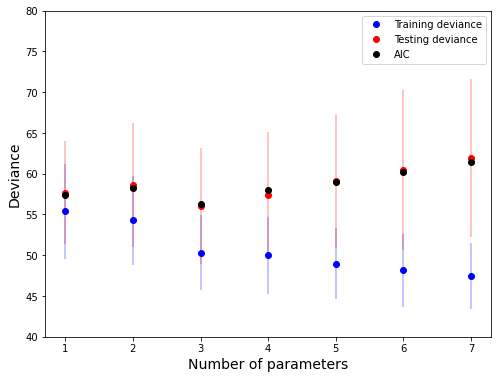

In [228]:
dev_train_avg = np.zeros(7)
dev_test_avg = np.zeros(7)
dev_train_sd = np.zeros(7)
dev_test_sd = np.zeros(7)
for i in range(7):
    dev_train, dev_test = sim(500, 20, 7, i, 100)
    dev_train_avg[i] = np.average(dev_train)
    dev_test_avg[i] = np.average(dev_test)
    dev_train_sd[i] = np.std(dev_train)
    dev_test_sd[i] = np.std(dev_test)
plt.figure(figsize=(8, 6))
plt.plot(range(1,8), dev_train_avg, 'o', label = 'Training deviance', color = 'blue')
plt.plot(range(1,8), dev_test_avg, 'o', label = 'Testing deviance', color = 'red')
plt.plot(range(1,8), dev_train_avg + 2 * np.arange(1,8), 'o',label = 'AIC', color = 'black')
plt.ylim((40, 80))
plt.xlabel('Number of parameters', size=14)
plt.ylabel('Deviance', size= 14)
for i in range(7):
    plt.vlines(x=i+1, ymin = dev_train_avg[i] - dev_train_sd[i], ymax = dev_train_avg[i] + dev_train_sd[i], color = 'blue', alpha = 0.3)
    plt.vlines(x=i+1, ymin = dev_test_avg[i] - dev_test_sd[i], ymax = dev_test_avg[i] + dev_test_sd[i], color = 'red', alpha = 0.3)
plt.legend()
plt.savefig('deviance_aic.png')

In [214]:
prior_sd = 0.5
model_0 = pm.Model()
model_1 = pm.Model()
model_2 = pm.Model()
model_3 = pm.Model()
model_4 = pm.Model()

with model_4:
    alpha = pm.Normal('alpha', 0, prior_sd)
    beta1 = pm.Normal('beta1', 0, prior_sd)
    beta2 = pm.Normal('beta2', 0, prior_sd)
    beta3 = pm.Normal('beta3', 0, prior_sd)
    beta4 = pm.Normal('beta4', 0, prior_sd)
    
    m = pm.Deterministic('m', alpha + beta1 * train[:, 1] + beta2 * train[:, 2] + beta3 * train[:, 3] + beta4 * train[:, 4])
    
    y = pm.Normal('y', m, sigma, observed = train[:,0])
    
    trace_4 = pm.sample(tune = 1000)

with model_3:
    alpha = pm.Normal('alpha', 0, prior_sd)
    beta1 = pm.Normal('beta1', prior_sd)
    beta2 = pm.Normal('beta2', prior_sd)
    beta3 = pm.Normal('beta3', prior_sd)
    
    m = pm.Deterministic('m', alpha + beta1 * train[:, 1] + beta2 * train[:, 2] + beta3 * train[:, 3])
    
    y = pm.Normal('y', m, sigma, observed = train[:,0])
    
    trace_3 = pm.sample(tune = 1000)
    summary_3 = pm.summary(trace_3, var_names = ['beta1', 'beta2', 'beta3'])
    
with pm.Model() as model_2:
    alpha = pm.Normal('alpha', 0, prior_sd)
    beta1 = pm.Normal('beta1', prior_sd)
    beta2 = pm.Normal('beta2', prior_sd)
    
    m = pm.Deterministic('m', alpha + beta1 * train[:, 1] + beta2 * train[:, 2])
    
    y = pm.Normal('y', m, sigma, observed = train[:,0])
    
    trace_2 = pm.sample(tune = 1000)

with pm.Model() as model_1:
    alpha = pm.Normal('alpha', 0, prior_sd)
    beta1 = pm.Normal('beta1', prior_sd)
    
    m = pm.Deterministic('m', alpha + beta1 * train[:, 1])
    
    y = pm.Normal('y', m, sigma, observed = train[:,0])
    
    trace_1 = pm.sample(tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta4, beta3, beta2, beta1, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 3646.85draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 3306.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 4263.17draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 3813.85draws/s]


In [215]:
waic_comp = az.compare({'model_1':trace_1, 'model_2':trace_2, 'model_3':trace_3, 'model_4':trace_4}, ic='waic', scale='deviance')
waic_comp

/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_2,0,49.9848,1.24274,0,0.597598,3.07518,0,False,deviance
model_3,1,51.7489,1.94018,1.7641,0.252699,3.32093,0.604136,False,deviance
model_4,2,53.139,2.31603,3.15417,0.139579,5.27815,1.23782,True,deviance
model_1,3,61.3833,1.85693,11.3985,0.0101237,2.74631,4.31194,False,deviance


In [216]:
loo_comp = az.compare({'model_1':trace_1, 'model_2':trace_2, 'model_3':trace_3, 'model_4':trace_4}, ic='loo', scale = 'deviance')
loo_comp

/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/opt/anaco

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_2,0,50.0461,1.27339,0,0.620241,2.99975,0,False,deviance
model_3,1,51.9171,2.02426,1.87096,0.244262,3.32768,0.637612,False,deviance
model_4,2,53.4191,2.45612,3.37303,0.126268,5.15648,1.31626,False,deviance
model_1,3,61.5239,1.92722,11.4778,0.00922876,2.66832,4.31673,False,deviance
